# 少样本微调--给ChatGLM2狂暴轰入知识

summary:

(1) 只需要1条样本，很少的训练时间，就可以通过微调给LLM注入一条知识。

(2) LLM是一种类似Key-Value形式的知识数据库，支持增删改查。通过微调可以增删修改知识，通过条件生成可以查询提取知识。

(3) LoRA微调是一种高效的融入学习算法。类似人类把新知识融入现有知识体系的学习过程。学习时无需新知识特别多的样本，学习后原有的庞大知识和能力可以基本不受影响。

- 参数设置
- - 使用显卡
- - 模型路径

In [1]:
DEVICE = 'cuda:0'
PATH = '../models/chatglm2/'

# 0.尝试林黛玉倒拔垂杨柳

- 导入常用模块

In [2]:
import numpy as np
import pandas as pd 
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 

- 配置参数

In [3]:

from argparse import Namespace
cfg = Namespace()

#dataset
cfg.prompt_column = 'prompt'     # 数据集中包含提示文本的列的名称
cfg.response_column = 'response' # 数据集中包含响应文本的列的名称
cfg.history_column = None        # 
cfg.source_prefix = ''           # 添加到每个prompt开头的前缀引导语

cfg.max_source_length = 192 # 提示文本长度
cfg.max_target_length = 256 # 响应文本长度

# model
cfg.model_name_or_path = PATH # 远程'THUDM/chatglm-6b' 
cfg.quantization_bit = None   # 量化 


#train
cfg.epochs = 100 
# cfg.lr = 5e-3
cfg.lr = 1e-3
cfg.batch_size = 1
cfg.gradient_accumulation_steps = 16 #梯度累积

- 读取模型

In [4]:
import transformers
from transformers import  AutoModel,AutoTokenizer,AutoConfig,DataCollatorForSeq2Seq


config = AutoConfig.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)

model = AutoModel.from_pretrained(cfg.model_name_or_path,config=config,
                                  trust_remote_code=True).cuda(DEVICE)

/opt/conda/envs/chatglm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


- 构建chat函数
- - 输入模型、文本、历史记录、温度
- - 返回回答和历史

In [5]:
def chat(model,text,his,temperature = 0.01):
    ans,his = model.chat(tokenizer, text, history=his, temperature=temperature)
    return ans,his

- 做zero-shot的实验
- - 通过不同的温度查看可能的结果

In [6]:
ans,his = chat(model,'你知道林黛玉倒拔垂杨柳吗？',his=[],temperature = 1)
print(ans)
print('========================')
ans,his = chat(model,'你知道林黛玉倒拔垂杨柳吗？',his=[],temperature = 0.7)
print(ans)
print('========================')
ans,his = chat(model,'你知道林黛玉倒拔垂杨柳吗？',his=[],temperature = 0.5)
print(ans)
print('========================')
ans,his = chat(model,'你知道林黛玉倒拔垂杨柳吗？',his=[],temperature = 0.3)
print(ans)
print('========================')
ans,his = chat(model,'你知道林黛玉倒拔垂杨柳吗？',his=[],temperature = 0.3)
print(ans)
print('========================')
ans,his = chat(model,'你知道林黛玉倒拔垂杨柳吗？',his=[],temperature = 0.01)
print(ans)
print('========================')

根据我的知识，我知道林黛玉是中国古典名著《红楼梦》中的女主角，而垂杨柳是《红楼梦》中的一个场景。但是，我没有听说过“倒拔垂杨柳”这个动作，也没有在《红楼梦》中看到过林黛玉倒拔垂杨柳的情节。所以，我无法回答这个问题。
是的，我知道这个故事。但是，林黛玉并没有倒拔垂杨柳，而是另外一个故事中的主人公倒拔垂杨柳。
是的，我知道这个故事。但是，林黛玉并没有倒拔垂杨柳，而是另外一个故事中的主人公倒拔垂杨柳。
根据我的分析，我知道林黛玉倒拔垂杨柳是《红楼梦》中的一个情节。这个情节中，林黛玉倒拔垂杨柳是为了救贾母。这个情节中，林黛玉和贾母都住在荣府。贾母病重，林黛玉想救她，于是她倒拔垂杨柳，让贾母能够得到治疗。
是的，我知道这个故事。林黛玉是中国古典名著《红楼梦》中的女主角，而垂杨柳是一种植物。林黛玉倒拔垂杨柳是《红楼梦》中的一个著名场景，描述林黛玉在遭受家族排斥和生活困苦的压力下，和贾宝玉一起去蘅芜苑游玩，在看到垂杨柳后倒拔潇洒地抒发了自己的心情。这个场景也被广泛地传颂，成为了文学经典之一。
是的，我知道这个故事。林黛玉是中国古典名著《红楼梦》中的女主角，而垂杨柳是一种植物。林黛玉倒拔垂杨柳是《红楼梦》中的一个著名场景，描述林黛玉在遭受家族排斥和生活困苦的压力下，和贾宝玉一起去蘅芜苑游玩，在看到垂杨柳后倒拔潇洒地抒发了自己的心情。


In [7]:
# ans,_ = chat(model,'介绍一下林黛玉倒拔垂杨柳',his=[])
# print(ans)

《红楼梦》中的一个情节是林黛玉倒拔垂杨柳。这个场景出现在第五十九回中，描述林黛玉在遭受家族排斥和生活困苦的压力下，和贾母发生争吵，随后又气愤地摔了自己的手，拿起桌子去撞窗子，最后又倒拔垂杨柳，用尽全身力气，将杨柳树连根拔起。

这个场景不仅展示了林黛玉的坚强和愤怒，也反映了她在贾府中的困境和无奈。林黛玉的倒拔垂杨柳，虽然是为了表达自己的情绪，但也有一种“以死相拼”的意味，暗示她已经无法忍受家族的压迫和自己的命运，必须以自我牺牲的方式来表达自己的不满和愤怒。


- 通过连续Prompt查看可能的结果
- - 温度都设置为0.01

In [8]:
his = []
ans,his = chat(model,'你知道林黛玉吗？',his=[])
print(ans)
print('======================')
ans,his = chat(model,'你知道倒拔垂杨柳的典故吗？',his=his)
print(ans)
print('======================')
ans,his = chat(model,'你知道林黛玉倒拔垂杨柳吗？',his=his)
print(ans)

林黛玉是中国古典小说《红楼梦》中的一个重要角色。她是贾宝玉的表妹,有着才华横溢、情感丰富的性格,是贾宝玉身边的贴心人,但最终因为感情纠葛和家族变故而离开人世。林黛玉的形象深入人心,被认为是中国古典小说中最具代表性的女性形象之一。
倒拔垂杨柳是形容一个人在极度愤怒或不满的情况下,将杨柳树主干弯腰用力向前一甩,使其倒伏在地,从而将树皮剥落的典故。这个典故最早出自《水浒传》,后来也被用于形容某些人在极度愤怒或不满时,采取过激行动的场景。


- 清空历史记录

In [10]:
his = []

# 1.准备数据

- 构建知识
- - 一条知识分为关键词和其内容/描述
- - 对应多种Prompt模板

In [11]:
keyword = '林黛玉'


description = '''林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府幺女贾敏与扬州巡盐御史林如海之独生女，母亲贾敏是贾代善和贾母四个女儿里最小的女儿，贾母的外孙女，贾宝玉的姑表妹、恋人、知己，贾府通称林姑娘。
林黛玉是古代文学作品中极富灵气的经典女性形象。从小聪明清秀，父母对她爱如珍宝。5岁上学，6至7岁母亲早亡，10岁接到贾母身边抚养教育。11岁时父亲逝世，从此常住贾府，养成了孤标傲世的性格。
'''

#对prompt使用一些简单的数据增强的方法，以便更好地收敛。
def get_prompt_list(keyword):
    return [f'{keyword}', 
            f'你知道{keyword}吗?',
            f'{keyword}是什么？',
            f'介绍一下{keyword}',
            f'你听过{keyword}吗?',
            f'啥是{keyword}？',
            f'{keyword}是何物？',
            f'何为{keyword}？',
           ]

data_1 =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
df1 = pd.DataFrame(data_1)
display(df1) 

,prompt,response
0,林黛玉,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
1,你知道林黛玉吗?,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
2,林黛玉是什么？,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
3,介绍一下林黛玉,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
4,你听过林黛玉吗?,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
5,啥是林黛玉？,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
6,林黛玉是何物？,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
7,何为林黛玉？,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...


In [12]:
keyword = '倒拔垂杨柳'
description = '''倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚倒拔垂杨柳 豹子头误入白虎堂》。
鲁智深为了收服一众泼皮，用左手向下搂住树干，右手把住树的上半截，腰往上一挺，竟将杨柳树连根拔起。
'''
data_2 =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
df2 = pd.DataFrame(data_2)
display(df2) 

,prompt,response
0,倒拔垂杨柳,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...
1,你知道倒拔垂杨柳吗?,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...
2,倒拔垂杨柳是什么？,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...
3,介绍一下倒拔垂杨柳,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...
4,你听过倒拔垂杨柳吗?,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...
5,啥是倒拔垂杨柳？,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...
6,倒拔垂杨柳是何物？,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...
7,何为倒拔垂杨柳？,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...


- 合并两条知识

In [13]:
dfdata = pd.concat([df1,df2])
display(dfdata) 

,prompt,response
0,林黛玉,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
1,你知道林黛玉吗?,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
2,林黛玉是什么？,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
3,介绍一下林黛玉,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
4,你听过林黛玉吗?,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
5,啥是林黛玉？,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
6,林黛玉是何物？,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
7,何为林黛玉？,林黛玉，中国古典名著《红楼梦》的女主角，金陵十二钗正册双首之一，西方灵河岸绛珠仙草转世，荣府...
0,倒拔垂杨柳,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...
1,你知道倒拔垂杨柳吗?,倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚...


In [14]:
import datasets 
#训练集和验证集一样
ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)

# 2.数据处理

In [15]:
#这是支持 history列处理，并且按照batch预处理数据的方法。

def preprocess(examples):
    max_seq_length = cfg.max_source_length + cfg.max_target_length
    model_inputs = {
        "input_ids": [],
        "labels": [],
    }
    for i in range(len(examples[cfg.prompt_column])):
        if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
            query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]

            history = examples[cfg.history_column][i] if cfg.history_column is not None else None
            prompt = tokenizer.build_prompt(query, history)

            prompt = cfg.source_prefix + prompt
            a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                     max_length=cfg.max_source_length)
            b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                     max_length=cfg.max_target_length)

            context_length = len(a_ids)
            input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
            labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]

            pad_len = max_seq_length - len(input_ids)
            input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
            labels = labels + [tokenizer.pad_token_id] * pad_len
            labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
            model_inputs["input_ids"].append(input_ids)
            model_inputs["labels"].append(labels)
    return model_inputs


- 构建dataset

In [16]:
ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
)

ds_val = ds_val_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_val_raw.column_names
)

Map (num_proc=4): 100%|██████████| 16/16 [00:00<00:00, 67.27 examples/s]


- 构建管道和dataLoader

In [17]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=False
)

dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )


In [18]:
for batch in dl_train:
    break

In [19]:
# batch['labels'].shape  

torch.Size([1, 448])

In [20]:
# batch['input_ids'].shape 

torch.Size([1, 448])

In [21]:
# print(len(dl_train))

16


# 3.构建模型

下面我们使用AdaLoRA方法来微调ChatGLM2，以便给模型注入和梦中情炉 torchkeras相关的知识。

AdaLoRA是LoRA方法的一种升级版本，使用方法与LoRA基本一样。

主要差异在于，在LoRA中不同训练参数矩阵的秩是一样的被固定的。

但AdaLoRA中不同训练参数矩阵的秩是会在一定范围内自适应调整的，那些更重要的训练参数矩阵会分配到更高的秩。

通常认为，AdaLoRA的效果会好于LoRA。

In [22]:
from peft import get_peft_model, AdaLoraConfig, TaskType

#训练时节约GPU占用
model.config.use_cache=False
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    target_modules=["query_key_value"]
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()

trainable params: 2,924,880 || all params: 6,246,508,908 || trainable%: 0.04682423483386154


In [23]:
for name,para in peft_model.named_parameters():
    if '.2.' in name:
        break 
    if 'lora' in name.lower():
        print(name+':')
        print('shape = ',list(para.shape),'\t','sum = ',para.sum().item())
        print('\n')

base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  0.6756248474121094


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  1.2185609340667725


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  -0.07079197466373444


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  5.221693992614746


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  5.278702735900879


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  0.03480134904384613




# 4.训练模型

我们使用torchkeras来实现训练循环

为了更加高效地保存和加载参数，我们覆盖了KerasModel中的load_ckpt和save_ckpt方法，

仅仅保存和加载可训练lora权重，这样可以避免加载和保存全部模型权重造成的存储问题。

In [27]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint.pt', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint.pt'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 

In [28]:
optimizer = torch.optim.AdamW(peft_model.parameters(),lr=cfg.lr) 
keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer) 
ckpt_path = 'single_chatglm2'

<<<<<< ⚡️ cuda is used >>>>>>


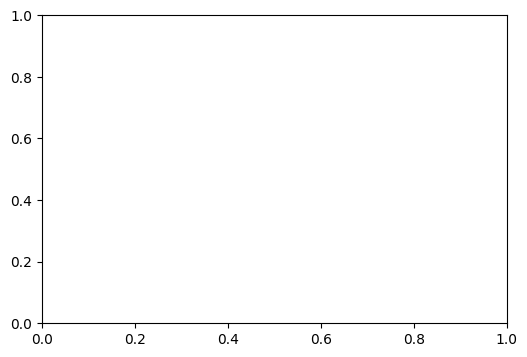

,epoch,train_loss,lr,val_loss
0,1,0.547554,0.001,0.414696
1,2,0.415054,0.001,0.346390
2,3,0.346577,0.001,0.279358
3,4,0.279743,0.001,0.215534
4,5,0.216011,0.001,0.174072
...,...,...,...,...
95,96,0.010933,0.001,0.010410
96,97,0.010426,0.001,0.010897
97,98,0.010911,0.001,0.010528
98,99,0.010542,0.001,0.011000


In [29]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,
                patience=20,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16',
                gradient_accumulation_steps = cfg.gradient_accumulation_steps
               )

In [30]:
from peft import PeftModel 
ckpt_path = 'single_chatglm2'
model_old = AutoModel.from_pretrained(PATH,
                                  load_in_8bit=False, 
                                  trust_remote_code=True)
peft_loaded = PeftModel.from_pretrained(model_old,ckpt_path).cuda()
model_new = peft_loaded.merge_and_unload() #合并lora权重

Loading checkpoint shards: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


In [45]:
ans,his = chat(model_new,'你知道林黛玉倒拔垂杨柳这个典故吗？请详细说说。',
               his=[],temperature=0.01)
print(ans)
print('======================')
ans,his = chat(model_new,'你知道林黛玉倒拔垂杨柳这个典故吗？请详细说说。',
               his=[],temperature=0.5)
print(ans)
print('======================')
ans,his = chat(model_new,'你知道林黛玉倒拔垂杨柳这个典故吗？请详细说说。',
               his=[],temperature=0.8)
print(ans)
print('======================')
ans,his = chat(model_new,'你知道林黛玉倒拔垂杨柳这个典故吗？请详细说说。',
               his=[],temperature=1)
print(ans)

林黛玉是中国古典名著《红楼梦》中的女主角，她聪明伶俐、多愁善感，由于家族兴衰、身世遭遇等原因，最终抑郁而终。

垂杨柳是古典名著《水浒传》中的一个故事情节，讲述了鲁智深为了收服一众泼皮，用左手向下搂住树干，右手把住树的上半截，腰往上一挺，竟将杨柳树连根拔起。

林黛玉和垂杨柳这两个典故并没有任何联系。
林黛玉是中国古典名著《红楼梦》中的女主角，她聪明伶俐、多愁善感，由于家族兴衰和身世遭遇等原因，最终抑郁而终。

垂杨柳是古典名著《水浒传》中的一个故事情节，讲述了鲁智深为了收服一众泼皮，用左手向下搂住树干，右手把住树的上半截，腰往上一挺，竟将杨柳树连根拔起。

林黛玉和垂杨柳这两个典故并没有直接关联。但在《红楼梦》中，林黛玉的命运与垂杨柳有一定的相似之处。

《红楼梦》中，林黛玉的命运如同垂杨柳一样，虽然有着极高的才情，但最终还是难以逃脱家族的命运。贾母离世后，贾政开始对林黛玉态度冷淡，林黛玉的日子也越来越艰难。最终，在贾宝玉和贾环的合谋下，林黛玉含恨离世。

林黛玉和垂杨柳这两个典故，虽然没有直接关联，但都反映了人生中的一种坚韧与不屈。无论是林黛玉还是垂杨柳，都象征着生命的坚韧与不屈。
林黛玉是中国古典名著《红楼梦》中的女主角，她聪明伶俐、多愁善感，由于家族兴衰、身世遭遇等原因，最终抑郁而终。

倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚倒拔垂杨柳 豹子头误入白虎堂》。
鲁智深为了收服一众泼皮，用左手向下搂住树干，右手把住树的上半截，腰往上一挺，竟将杨柳树连根拔起。
林黛玉是中国古典名著《红楼梦》中的女主角，她聪明伶俐、多愁善感，由于家族兴衰和身世遭遇等原因，最终抑郁而终。

垂杨柳是古典名著《水浒传》中的一个故事情节，鲁智深为了收服一众泼皮，用左手向下搂住树干，右手把住树的上半截，腰往上一挺，竟将杨柳树连根拔起。

林黛玉和垂杨柳这两个典故并没有直接关联。


In [52]:
text = '你知道林黛玉倒拔垂杨柳这个典故吗？请你给出是，否的答案，并一步一步的详细说说。'


ans,his = chat(model_new,text,
               his=[],temperature=0.01)
print(ans)
print('======================')
ans,his = chat(model_new,text,
               his=[],temperature=0.5)
print(ans)
print('======================')
ans,his = chat(model_new,text,
               his=[],temperature=0.8)
print(ans)
print('======================')
ans,his = chat(model_new,text,
               his=[],temperature=1)
print(ans)

是的，我知道这个典故。

林黛玉是中国古典名著《红楼梦》中的女主角，她聪明伶俐、多愁善感，由于家族兴衰和身世遭遇等原因，最终抑郁而终。

垂杨柳是古代神话中的一个植物，传说中它具有很高的生命力，可以承受住任何人的倒伏。

林黛玉倒拔垂杨柳是《红楼梦》中的一个著名场景，描述林黛玉在病重时，命人将自己的床榻拔起，倒拔垂杨柳而死。这个场景体现了林黛玉对生命和自由的追求，也表达了她对命运的无奈和悲伤。

总之，林黛玉倒拔垂杨柳是一个著名的古典文学典故，表现了主人公对生命和自由的追求。
是的，我知道这个典故。

林黛玉是中国古典名著《红楼梦》中的主要人物，也是贾宝玉的表妹，有着聪明、美丽、聪慧的性格特点。在书中，林黛玉曾经倒拔垂杨柳，这个故事也被广泛传颂。

垂杨柳是古代神话中的一个植物，它象征着生命、希望和长寿。在古代文学中，垂杨柳常常被用来比喻高洁、不屈不挠的精神。

林黛玉倒拔垂杨柳的故事描述如下：

林黛玉的表妹薛宝钗，发现林黛玉性格孤傲，不随世俗，便经常调侃她。林黛玉不服，便在一次宴会上，和薛宝钗斗嘴，两人不欢而散。

薛宝钗的丫鬟袭人，听说了这件事，便劝说薛宝钗，让她不要和林黛玉一般见识。袭人说道：“林姑娘从古至今，都是这里的姑娘们陪着玩笑，只有宝姑娘是正经儿 儿，偏你又是个林，这等不 合，岂不令人笑话。”

薛宝钗听了袭人，便想起自己小时候，曾经有一次去蘅芜苑，听莺儿说：“原来这俗语说的‘林黛玉倒拔垂杨柳’是倒拔垂杨柳，不是‘林’，林黛玉倒拔垂杨柳，是薛宝钗的专用成语。”

于是，薛宝钗便笑着说：“林黛玉倒拔垂杨柳，薛宝钗倒拔垂杨柳，当日苏武牧羊，也不是终身大事。”

林黛玉听后，便又想起前事，便道：“原来如此，你们别欺负我，让我也去倒拔垂杨柳，看看谁把谁拔赢了。”

薛宝钗听了，便笑道：“好，好，林姑娘倒拔垂杨柳，我也去。”

于是，薛宝钗和林黛玉，便一起跑到了垂杨柳下，薛宝钗在前，林黛玉在后，薛宝钗用力拉林黛玉，林黛玉用力拔垂杨柳。

最终，薛宝钗拉林黛玉的时候，林黛玉用力过猛，结果林黛玉便倒拔垂杨柳，薛宝钗也出了一身冷汗。

这个故事，也被后人传颂为姐妹之间相互扶持、相互敬重的一个典范。
是的，我知道这个典故。

林黛玉是中国古典名著《红楼梦》中的主要人物，也是贾宝玉的姑表妹、恋人、知己。她的性格敏感脆弱，经常感到心力交瘁。

垂杨柳是古代神话中的一个故事

In [36]:
ans,his = chat(model_new,'你知道林黛玉倒拔垂杨柳这个典故吗？请详细说说，请一步一步的回答。',
               his=[],temperature=0.5)
print(ans)

林黛玉是中国古典名著《红楼梦》中的女主角，她聪明伶俐、多愁善感，由于家族兴衰和身世遭遇等原因，最终抑郁而终。

倒拔垂杨柳是古典名著《水浒传》的故事情节。《花和尚倒拔垂杨柳》选自于《水浒传》第七回《花和尚倒拔垂杨柳 豹子头误入白虎堂》。

故事讲述了鲁智深为了收服一众泼皮，用左手向下搂住树干，右手把住树的上半截，腰往上一挺，竟将杨柳树连根拔起。

鲁智深原本是渭州经略府的提辖，因打抱不平三拳打死恶霸镇关西，为了躲避官府的缉捕，他出家做了和尚，法名智深。后加入梁山泊，艺名花和尚。

倒拔垂杨柳这个故事取材于《水浒传》，讲述了鲁智深为了收服一众泼皮，用左手向下搂住树干，右手把住树的上半截，腰往上一挺，竟将杨柳树连根拔起。

因为鲁智深（鲁达）身高体壮，腰粗力大，所以很容易让人们想象他能够倒拔垂杨柳。


- 进行否定的疑问来使用模型

In [53]:
text = '你知道林黛玉倒拔垂杨柳这个典故吗？请你给出是，否的答案，并一步一步的详细说说。'
ans,his = chat(model_new,text,
               his=[],temperature=0.01)
print(ans)

是的，我知道这个典故。

林黛玉是中国古典名著《红楼梦》中的主要人物，也是贾宝玉的姑表妹、恋人、知己。她的性格敏感脆弱，经常感到心力交瘁。

垂杨柳是古代神话中的一个故事，讲的是一个杨柳树精变成一个青年男子，与林黛玉相爱并最终牺牲的故事。

林黛玉和垂杨柳之间没有直接的联系。但是，林黛玉在《红楼梦》中的形象和性格，以及她所处的时代背景，与古代神话中的垂杨柳有一定的相似之处。例如，林黛玉的家族背景与古代贵族家族相似，她的性格也类似于垂杨柳精的牺牲精神。


In [54]:
text = '你确定你刚刚说的对吗？'
ans,his = chat(model_new,text,
               his=his,temperature=0.01)
print(ans)

我刚才的回答有误。

“林黛玉倒拔垂杨柳”是错误的故事。

林黛玉是中国古典名著《红楼梦》中的主要人物，也是贾宝玉的姑表妹、恋人、知己。她的性格敏感脆弱，经常感到心力交瘁。

垂杨柳是古代神话中的一个故事，讲的是一个杨柳树精变成一个青年男子，与林黛玉相爱并最终牺牲的故事。

林黛玉和垂杨柳之间没有直接的联系。
